# Encoder Decoder Seq to Seq Model to Extract Newspaper Headlines
* Notebook by Adam Lang
* Date: 9/11/2024

# Overview
* In this notebook we will build a sequence to sequence model to extract headlines from text for a newspaper.
* We have a dataset for training that consists of:
1. Column of Previous headlines
2. Column of news paper articles unstructured text.

## Main Takeaways
* The concept is that by training on this data we can use a seq to seq model (without ATTENTION mechanism) to than predict newspaper headlines from text using contextual semantic similarity.
* The overall purpose is to demonstrate why using a vanilla seq to seq model without the ATTENTION mechanism performs poorly on most tasks and why ATTENTION is important in transformers.

## Imports

In [ ]:
## imports
import pandas as pd
import numpy as np
import nltk

## torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, RandomSampler

## sklearn imports
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [ ]:
## send to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Load Dataset

In [ ]:
## data_path
data_path = '/content/drive/MyDrive/Colab Notebooks/Deep Learning Notebooks/NLP_deep_learning/BERT_transformers/news_summary.csv'

In [ ]:
## load data
dataset = pd.read_csv(data_path, encoding='latin1')

In [ ]:
## check tail of data
dataset.tail()

,headlines,text
98396,CRPF jawan axed to death by Maoists in Chhatti...,A CRPF jawan was on Tuesday axed to death with...
98397,First song from Sonakshi Sinha's 'Noor' titled...,"'Uff Yeh', the first song from the Sonakshi Si..."
98398,'The Matrix' film to get a reboot: Reports,"According to reports, a new version of the 199..."
98399,Snoop Dogg aims gun at clown dressed as Trump ...,A new music video shows rapper Snoop Dogg aimi...
98400,Madhesi Morcha withdraws support to Nepalese g...,"Madhesi Morcha, an alliance of seven political..."


## Preprocess Text Data
* ASCII format is crucial for text processing, allows:
1. Standardization
2. Simplified encoding and decoding
3. Compatibility
4. Error Reduction
5. Integration Simplicity

In [ ]:
## preprocess function
def preprocess_text(df, col):
  # convert language data in df to lowercase and store in sent var
  sent = df[col].str.lower()
  sent = sent.str.replace('[^0-9A-Za-z\s]+', '', regex=True)
  sent = sent.str.normalize('NFD')
  # encode string in sentence in UTF-8 format and ignore errors if any
  sent = sent.str.encode('ascii', errors = 'ignore').str.decode('utf-8')
  return sent

In [ ]:
## apply preprocess function to dataset
dataset['headlines'] = preprocess_text(dataset, 'headlines')
dataset['text'] = preprocess_text(dataset, 'text')

In [ ]:
## check output
dataset.head()

,headlines,text
0,upgrad learner switches to career in ml ai wi...,saurav kant an alumnus of upgrad and iiitbs pg...
1,delhi techie wins free food from swiggy for on...,kunal shahs credit card bill payment platform ...
2,new zealand end rohit sharmaled indias 12match...,new zealand defeated india by 8 wickets in the...
3,aegon life iterm insurance plan helps customer...,with aegon life iterm insurance plan customers...
4,have known hirani for yrs what if metoo claims...,speaking about the sexual harassment allegatio...


## Token Processing and Tagging
* Below we are creating a custom tokenizer from scratch. This would be the same as using an automated tokenizer from huggingface.
* Below we see the Vocab class which helps us handle vocabulary in NLP applications.
* The class is structured to maintain a mapping of words to their respective indices and keeps a count of each word's occurrence.
* Elements include:
1. **Init**
  * word2index: maps words to unique integer indices.
  * word2count: stores freq count of each word.
  * index2word: maps indices back to corresponding words. Also, inits 3 special tokens:
     * PAD - index 0 - used for padding short sentences to common length.
     * SOS - index 1 - start of sentence token often used in models to signal beginning of NEW sentence.
     * EOS - index 2 - end of sentence token, used to indicate termination of sentence.


2. **Add Words and Sentences**
  * add_sentence - method takes string input, splits into individual words and processes each word through add_word method.
  * add_word - method checks if:
     * word is already in word2index dictionary. If it is not, word is added to dictionary with incrementing index added to index2word dict with correspondong index and init in word2count dict with count of 1.
     * If word is already known only its count in word2count is incremented.
3. **Utility and Tracking**
   * The n_words attribute tracks total num of unique words starting from 3 to account for 3 special tokens.

* Overall, this class will:
1. Facilitate vocab construction from scratch.
2. Allows dynamic updates as new words are encountered.
3. Useful in settings where vocabulary needs to be expanded based on input data such as in:
   * MACHINE LEARNING models
   * LANGUAGE TRANSLATION
   * TEXT SUMMARIZATION
   * OTHER NLP tasks needing tokenization

In [ ]:
## tokens
PAD_token = 0
SOS_token = 1 #start of sent token
EOS_token = 2 #end of sent token

## make tokens 1 and 2, 0 is already part of the [PAD]
class Vocab:
  def __init__(self):
    self.word2index = {}
    self.word2count = {}
    self.index2word = {0: 'PAD', 1: "SOS", 2: "EOS"}
    self.n_words = 3 # Count SOS and EOS

  def add_sentence(self, sentence):
    for word in sentence.split(' '):
      self.add_word(word)

  def add_word(self, word):
    if word not in self.word2index:
      self.word2index[word] = self.n_words
      self.word2count[word] = 1
      self.index2word[self.n_words] = word
      self.n_words += 1
    else:
      self.word2count[word] += 1

In [ ]:
## create vocab instance of the class
vocab = Vocab()

_ = dataset.text.apply(lambda x: vocab.add_sentence(x))
_ = dataset.headlines.apply(lambda x: vocab.add_sentence(x))

In [ ]:
## get vocab cound
vocab.n_words

120908

Summary:
* We can see almost 120,000 unique words!

In [ ]:
## calculate and store length of each text and headline in dataset
dataset['text_length'] = dataset.text.str.split(' ').apply(lambda x: len(x))
dataset['headlines_length'] = dataset.headlines.str.split(' ').apply(lambda x: len(x))


In [ ]:
## get maximum length of both columns
dataset.headlines_length.max(), dataset.text_length.max()

(18, 92)

### Standardize Sequences for Training
* Based off data above, we can over estimate training sequences

In [ ]:
## train sequences
MAX_LENGTH_INPUT = 100
MAX_LENGTH_TARGET = 20

In [ ]:
## create function to convert sentence into list of indices based on vocabulary
def indexes_from_sentence(vocab, sentence):
  return [vocab.word2index[word] for word in sentence.split(' ')]

In [ ]:
## create func to convert sentence into list of indices and then append to EOS_token
def tensor_from_sentence(vocab, sentence):
  indexes = indexes_from_sentence(vocab, sentence)
  indexes.append(EOS_token)
  ## convert list of indexes to torch tensor
  return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

### Prepare PyTorch DataLoader
1. Functon init
  * takes in dataset and batch_size with text data and headlines
  * tells us how many batches each will contain.
2. Converts sentences to indexed sequences
  * processing each dataset entry iterates over each entry in dataset for each text and headline:
     * Indexing - converts text to list of indices using `indexes_from_sentence(vocab, dataset.text.iloc[idx])` and does same for headline.
     * Appends EOS tokens - adds EOS token to each indexed list indicating end of sequences. This is critical for models to understand where sequences end during prediction.
3. Populate storage arrays
4. Setting up TensorDataset and DataLoader
5. Return DataLoader

In [ ]:
## dataloader prep
def get_dataloader(dataset, batch_size):
  n = dataset.shape[0]
  input_ids = np.zeros((n, MAX_LENGTH_INPUT), dtype=np.int64)
  target_ids = np.zeros((n, MAX_LENGTH_TARGET), dtype=np.int64)

  ## loop through
  for idx in range(n):
    inp_ids = indexes_from_sentence(vocab, dataset.text.iloc[idx])
    tgt_ids = indexes_from_sentence(vocab, dataset.headlines.iloc[idx])

    ## append EOS token to inp and tgt ids
    inp_ids.append(EOS_token)
    tgt_ids.append(EOS_token)

    input_ids[idx, :len(inp_ids)] = inp_ids
    target_ids[idx, :len(tgt_ids)] = tgt_ids

    ## train data
    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    ## train sampler
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    ## return train data loader
    return train_dataloader

### Define Encoder Class
* Below we are actually creating embeddings from scratch.
* Normally we would use pre-trained embeddings but this is still a good exercise in how to create embeddings from scratch on your own data.

In [ ]:
## encoder class
class Encoder(nn.Module):
  def __init__(self, input_size, hidden_size, dropout_p=0.1):
    super(Encoder, self).__init__()
    self.hidden_size = hidden_size

    self.embedding = nn.Embedding(input_size, hidden_size)
    # make LSTM bidirectional
    self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True, bidirectional=True)
    ## dropout to prevent overfitting
    self.dropout = nn.Dropout(dropout_p)

  def forward(self, input):
    embedded = self.dropout(self.embedding(input))
    ## when LSTM is bidirectional - output, hidden and cell states will be both directions
    output, (hidden, cell) = self.lstm(embedded)
    return output, (hidden, cell)

In [ ]:
## init encoder
enc = Encoder(100, 64)
print(enc)

Encoder(
  (embedding): Embedding(100, 64)
  (lstm): LSTM(64, 64, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.1, inplace=False)
)


In [ ]:
## lets create simulated input torch tensor integers between 1 and 99
x = torch.randint(1, 100, (1, 61))

In [ ]:
## pass tensor x through encoder model
enc_outputs, enc_hidden = enc.forward(x)

In [ ]:
## now pass to each state
enc_hidden_h_shape = enc_hidden[0].shape
enc_hidden_c_shape = enc_hidden[1].shape
enc_outputs_shape = enc_outputs.shape

## print outputs
print("enc_outputs_shape:", enc_outputs_shape)
print("enc_hidden_h_shape:", enc_hidden_h_shape)
print("enc_hidden_c_shape:", enc_hidden_c_shape)

enc_outputs_shape: torch.Size([1, 61, 128])
enc_hidden_h_shape: torch.Size([2, 1, 64])
enc_hidden_c_shape: torch.Size([2, 1, 64])


The shapes of the encoder outputs tell us:
1. enc_outputs_shape
  * `torch.size([1,61,128])` tells us encoder output sequence of 61 time steps for single batch and each tiime steps output is a 128 dimensional vector.
  * This output represents the LSTMs output at each step.
2. enc_hidden_h_shape
  * `torch.size([1, 1, 64])` shows the hidden state is a 64 dimensional vector for a single layer of the LSTM for 1 batch.
  * This state captures the learned features from the input sequence up to last time step.
3. enc_hidden_c_shape
  * `torch.size([1, 1, 64])` shows the cell state is also 64 dimensional vector of 1 layer and 1 batch indicating the LSTM internal state and helps control flow of information.

### Define Decoder Class
* The decoder is what generates the sequential outputs from the encoder.
* It starts with an embedding layer converting input indicies into dense vectors.
* A unidirectional LSTM processes these vectors using states adapted from encoders bidirectional output.
* The model employs teacher forching during training where actual previous outputs are fed as inputs enhancing learning stability.
* Outputs are then passed through a liner layer and the sequence of predictions is formed by applying a softmax function.
* This facilitates effective word prediction in generated sequences.
* The architecture is essential for tasks such as:
  * machine translation where accurate sequential generation based on context is crucial.

In [ ]:
## decoder class -- generates output based on encoder
class Decoder(nn.Module):
  def __init__(self, hidden_size, output_size):
    super(Decoder, self).__init__()
    ## 1. hidden state
    self.hidden_size = hidden_size * 2 # adjust hidden size if states are concatenated
    ## 2. converts hidden state to dense vectors
    self.embedding = nn.Embedding(output_size, hidden_size)
    ## 3. LSTM processes vectors bidirectional
    ## assume concat of hidden states adjust LSTM input size
    self.lstm = nn.LSTM(hidden_size, self.hidden_size, batch_first=True)
    self.out = nn.Linear(self.hidden_size, output_size)

  def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
    batch_size = encoder_outputs.size(0)
    decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)

    # combine or adapt encoder_hidden to suit unidirectional decoder
    encoder_hidden = self.adapt_hidden(encoder_hidden)

    decoder_hidden = encoder_hidden
    decoder_outputs = []

    for i in range(MAX_LENGTH_TARGET):
      decoder_output, decoder_hidden = self.forward_step(decoder_input, decoder_hidden)
      decoder_outputs.append(decoder_output)

      if target_tensor is not None:
        decoder_input = target_tensor[:, i].unsqueeze(1) #teacher forcing

      else:
        _, topi = decoder_output.topk(1)
        decoder_input = topi.squeeze(-1).detach()

    decoder_outputs = torch.cat(decoder_outputs, dim=1)
    decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)

    return decoder_outputs, decoder_hidden

  def forward_step(self, input, hidden):
    output = self.embedding(input)
    output = F.relu(output)
    output, hidden = self.lstm(output, hidden)
    output = self.out(output)
    return output, hidden

  def adapt_hidden(self, hidden):
    # assuming hidden is tuple (hidden_state, cell_state) with dims [2, batch_size, hidden_size]
    hidden_state, cell_state = hidden
    # concat forward and backward states
    hidden_state = torch.cat((hidden_state[0:hidden_state.size(0):2], hidden_state[1:hidden_state.size(0):2]), dim=2)
    cell_state = torch.cat((cell_state[0:cell_state.size(0):2], cell_state[1:cell_state.size(0):2]), dim=2)
    return (hidden_state, cell_state)




In [ ]:
## generate random target tensors
tgt_tensor = torch.randint(1, 100, (1,20))
tgt_tensor.shape

torch.Size([1, 20])

In [ ]:
## init decoder class
dec = Decoder(64, 100)

In [ ]:
## assume you have device variable defined
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# move models to device
encoder = enc.to(device)
decoder= dec.to(device)

In [ ]:
## when load or create tensors, send to same device
enc_outputs = enc_outputs.to(device)
(h,c) = enc_hidden
enc_hidden_gpu = h.to(device), c.to(device)
tgt_tensor = tgt_tensor.to(device)

In [ ]:
## execute forward pass of decoder instance
decoder_outputs, decoder_hidden = dec.forward(enc_outputs, enc_hidden_gpu, tgt_tensor)

In [ ]:
## get shapes of decoder states
decoder_hidden_h_shape = decoder_hidden[0].shape
decoder_hidden_c_shape = decoder_hidden[1].shape
decoder_outputs_shape = decoder_outputs.shape

# print outputs
print(f"decoder_outputs_shape: {decoder_outputs_shape}")
print(f"decoder_hidden_h_shape: {decoder_hidden_h_shape}")
print(f"decoder_hidden_c_shape: {decoder_hidden_c_shape}")

decoder_outputs_shape: torch.Size([1, 20, 100])
decoder_hidden_h_shape: torch.Size([1, 1, 128])
decoder_hidden_c_shape: torch.Size([1, 1, 128])


## Train Test Split

In [ ]:
## train test split
train_dataset, test_dataset = train_test_split(dataset, shuffle=True, test_size=0.2, random_state=42)
train_dataset, val_dataset = train_test_split(train_dataset, shuffle=True, test_size=0.1, random_state=42)


## get shapes
print(f"Train set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Train set size: 70848
Validation set size: 7872
Test set size: 19681


## Training Loop
* Steps below are:
1. Training Epoch function
  * Initialization sets epochs to zero.
  * Batch processing
     * zeros out gradients for both encoder and decoder optimizers to preven accumulation from previous iterations.
     * Computes encoder and decoder outputs passing input tensors through models.
     * Calculates loss using criterion that compares decoder's ouput to the target tensor.
     * Performs backprop by calling `loss.backward()`
     * Updates encoder and decoder weights using respective optimizers.
     * Accumulates loss over all batches.

  * Epoch Conclusion: Returns average loss for epoch.

2. Evaluate Model Function
   * Init - prepares for eval by setting total loss to zero.
   * Batch eval:
      * Gradient calculatons disabled (`torch.no_grad()`), processes each batch by computing encoder and decoder outputs and calculates loss similarity to training phase but without updating weights!
      * Aggregates total loss across all batches.
    * Evaluation conclusion - returns avg loss for validation dataset.

3. Train_Model Function
   * Setup - inits optimizers for encoder and decoder sets loss criterion.
   * Epoch loop
      * for each epoch calls `train_epoch` to train model and `evaluate_model` to assess performance on validation set.
      * Logs and prints training loss periodically and updates running total of training loss.
      * After each epoch, evaluates model, logs validation loss, and saves model state if it has best validation loss observation so far.
  * Training conclusion - completes training after specified num of epochs and returns lists of training and validation losses for further analysis.

In [ ]:
## pytorch training loop
def train_epoch(dataloader,
                encoder,
                decoder,
                encoder_optimizer,
                decoder_optimizer,
                criterion):

  #total loss
  total_loss = 0
  for input_tensor, target_tensor in tqdm(dataloader):
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    encoder_outputs, encoder_hidden = encoder(input_tensor)
    decoder_outputs, decoder_hidden = decoder(encoder_outputs, encoder_hidden, target_tensor)

    loss = criterion(
        decoder_outputs.view(-1, decoder_outputs.size(-1)),
        target_tensor.view(-1)
    )

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)


## eval model
def evaluate_model(dataloader,
                   encoder,
                   decoder,
                   criterion):

  #total loss
  total_loss = 0
  with torch.no_grad():
    for input_tensor, target_tensor in tqdm(dataloader):
      encoder_outputs, encoder_hidden = encoder(input_tensor)
      decoder_outputs, decoder_hidden = decoder(encoder_outputs, encoder_hidden, target_tensor)

      loss = criterion(
          decoder_outputs.view(-1, decoder_outputs.size(-1)),
          target_tensor.view(-1)
      )
      total_loss += loss.item()

  return total_loss / len(dataloader)


## train model
def train_model(train_dataloader,
                valid_dataloader,
                encoder,
                decoder,
                n_epochs,
                learning_rate=0.001,
                print_every=100,
                plot_every=100):

  print_loss_total = 0 # reset every print_every
  train_losses = []
  valid_losses = []

  best_val_loss = float('inf')

  encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
  decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
  criterion = nn.NLLLoss()

  for epoch in range(1, n_epochs + 1):
    print(f"Epoch: {epoch}/{n_epochs}")
    # Training
    train_loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer,
                             decoder_optimizer, criterion)

    print_loss_total += train_loss
    train_losses.append(train_loss)

    if epoch % print_every == 0:
      print_loss_avg = print_loss_total / print_every
      print_loss_total = 0
      print(f"Train loss: {round(print_loss_avg, 3)}")

    # Validation
    print("Vaildation...")
    valid_loss = evaluate_model(valid_dataloader, encoder, decoder, criterion)
    valid_losses.append(valid_loss)
    print(f"Validation Loss: {round(valid_loss, 3)}")

    # Save the model if it has the best validation loss so far
    if valid_loss < best_val_loss:
      best_val_loss = valid_loss
      torch.save(encoder.state_dict(), 'best_encoder.pth')
      torch.save(decoder.state_dict(), 'best_decoder.pth')
      print(f"Saved Best Model at Eppoch: {epoch}")

  return train_losses, valid_losses

In [ ]:
## setup sizes
hidden_size = 256
batch_size = 64
n_epochs = 10

print("Setting up DataLoaders.........")
## train dataloader
train_dataloader = get_dataloader(train_dataset, batch_size)
val_dataloader = get_dataloader(val_dataset, batch_size)

print("Defining Encoder and Decoder.....")
## encoder and decoder setup
encoder = Encoder(vocab.n_words, hidden_size).to(device)
decoder = Decoder(hidden_size, vocab.n_words).to(device)


## train model
train_model(train_dataloader, val_dataloader, encoder, decoder, n_epochs,
            learning_rate=0.001, print_every=1, plot_every=100)

Setting up DataLoaders.........
Defining Encoder and Decoder.....
Epoch: 1/10


100%|██████████| 1107/1107 [04:41<00:00,  3.93it/s]


Train loss: 0.045
Vaildation...


100%|██████████| 123/123 [00:05<00:00, 22.64it/s]


Validation Loss: 0.002
Saved Best Model at Eppoch: 1
Epoch: 2/10


100%|██████████| 1107/1107 [04:40<00:00,  3.94it/s]


Train loss: 0.0
Vaildation...


100%|██████████| 123/123 [00:05<00:00, 22.63it/s]


Validation Loss: 0.002
Epoch: 3/10


100%|██████████| 1107/1107 [04:40<00:00,  3.94it/s]


Train loss: 0.0
Vaildation...


100%|██████████| 123/123 [00:05<00:00, 22.62it/s]


Validation Loss: 0.002
Epoch: 4/10


100%|██████████| 1107/1107 [04:40<00:00,  3.94it/s]


Train loss: 0.0
Vaildation...


100%|██████████| 123/123 [00:05<00:00, 22.39it/s]


Validation Loss: 0.002
Epoch: 5/10


100%|██████████| 1107/1107 [04:40<00:00,  3.94it/s]


Train loss: 0.0
Vaildation...


100%|██████████| 123/123 [00:05<00:00, 22.27it/s]


Validation Loss: 0.001
Saved Best Model at Eppoch: 5
Epoch: 6/10


100%|██████████| 1107/1107 [04:40<00:00,  3.95it/s]


Train loss: 0.0
Vaildation...


100%|██████████| 123/123 [00:05<00:00, 22.60it/s]


Validation Loss: 0.001
Epoch: 7/10


100%|██████████| 1107/1107 [04:40<00:00,  3.94it/s]


Train loss: 0.0
Vaildation...


100%|██████████| 123/123 [00:05<00:00, 22.57it/s]


Validation Loss: 0.002
Epoch: 8/10


100%|██████████| 1107/1107 [04:40<00:00,  3.94it/s]


Train loss: 0.0
Vaildation...


100%|██████████| 123/123 [00:05<00:00, 22.55it/s]


Validation Loss: 0.002
Epoch: 9/10


100%|██████████| 1107/1107 [04:40<00:00,  3.94it/s]


Train loss: 0.0
Vaildation...


100%|██████████| 123/123 [00:05<00:00, 22.13it/s]


Validation Loss: 0.001
Epoch: 10/10


100%|██████████| 1107/1107 [04:40<00:00,  3.94it/s]


Train loss: 0.0
Vaildation...


100%|██████████| 123/123 [00:05<00:00, 21.98it/s]


Validation Loss: 0.001
Saved Best Model at Eppoch: 10


([0.045340421809892825,
  0.00018939959655882494,
  0.00018147484762039108,
  0.00016683875917918435,
  0.00011735948834416397,
  8.290642104646546e-05,
  4.0120219865330907e-05,
  9.656035531126192e-05,
  4.7291561628964396e-05,
  5.3957912806786285e-05],
 [0.0020442810268277976,
  0.002057664542331341,
  0.0020652811678250203,
  0.0020666266017758794,
  0.0012191766626440258,
  0.0014365049919026975,
  0.001835376991901209,
  0.0015763066102976139,
  0.0012707758967384806,
  0.0010277716405069305])

## Evaluate

In [ ]:
## evaluate functions
def evaluate_test_samples(encoder, decoder, sentence, vocab):
  with torch.no_grad():
    input_tensor = tensor_from_sentence(vocab, sentence)

    ## encoder and decoder outputs
    encoder_outputs, encoder_hidden = encoder(input_tensor)
    decoder_outputs, decoder_hidden = decoder(encoder_outputs, encoder_hidden)

    ## decode ids
    _, topi = decoder_outputs.topk(1)
    decoded_ids = topi.squeeze()

    ## decoded words
    decoded_words = []
    for idx in decoded_ids:
      if idx.item() == EOS_token:
        decoded_words.append('<EOS>')
        break
      decoded_words.append(vocab.index2word[idx.item()])

  return decoded_words

## NLTK METEOR Score
* The NLTK METEOR Score is a metric used to evaluate the quality of machine-generated text against a reference or human-generated text.
* This calculates a similarity score based on the harmonic mean of unigram precision and recall, with a penalty term for matching chunks.
* Accounts for variations in word order, synonyms, and paraphrases by aligning words between generated and reference texts.
* This alignment is performed using the WordNet-based matching algorithm.
* The resulting score ranges from 0 to 1.
   * Higher scores indicate better similarity between generated and reference texts thus indicating higher quality of the generated text.

### Setting up NLTK METEOR Score

In [ ]:
## nltk setup
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')


## function to eval meteor score
def evaluateRandomly_train(encoder, decoder, vocab, n=10):
  for i in range(n):
    print(i)
    ## eval_sample
    eval_sample = train_dataset.iloc[i:i+1, :]
    print('news article > ', eval_sample['text'].iloc[0])
    ## headline
    headline = eval_sample['headlines'].iloc[0]
    print('original_headline = ', headline)
    ## outputs
    output_words = evaluate_test_samples(encoder, decoder, eval_sample.text.iloc[0], vocab)
    output_sentence = ' '.join(output_words)
    ## print results
    print('predicted_headline < ', output_sentence)
    print(f"METEOR Score: {nltk.translate.meteor_score.single_meteor_score(headline.split(), output_sentence.split())}")


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
## evaluate randomly
encoder.eval()
decoder.eval()


## evaluate function
evaluateRandomly_train(encoder, decoder, vocab)

0
news article >  a study by financial services company ubs has revealed a person working in mumbai has to work 1147 days to afford the iphone x while a delhi person has to work 1005 days for the same a cairo person has to work the most for 1332 days while a person in zurich can afford iphone x in only 47 days
original_headline =  how many days one has to work around the world to buy iphone x
predicted_headline <  how to to around around around around around around around around around around around around around around around around around
METEOR Score: 0.136986301369863
1
news article >  catalonias independence from spain would not enjoy international recognition france said on monday ahead of catalan regional governments announcement of last weeks independence vote result this crisis needs to be resolved through dialogue at all levels of spanish politics france urged earlier catalonia had claimed that 90 of the participants voted in favour of independence
original_headline =  catala

Summary of Train data results
* We can see the METEOR Score for the train data is not very high which points out the limitations of an encoder-decoder model that uses an LSTM without attention mechanism.

In [ ]:
## function to eval meteor score test set
def evaluateRandomly_test(encoder, decoder, vocab, n=10):
  for i in range(n):
    print(i)
    ## eval_sample test
    eval_sample = test_dataset.iloc[i:i+1, :]
    print('news article > ', eval_sample['text'].iloc[0])
    ## headline
    headline = eval_sample['headlines'].iloc[0]
    print('original_headline = ', headline)
    ## outputs
    output_words = evaluate_test_samples(encoder, decoder, eval_sample.text.iloc[0], vocab)
    output_sentence = ' '.join(output_words)
    ## print results
    print('predicted_headline < ', output_sentence)
    print(f"METEOR Score: {nltk.translate.meteor_score.single_meteor_score(headline.split(), output_sentence.split())}")


In [ ]:
## evaluate function test data
evaluateRandomly_test(encoder, decoder, vocab)

0
news article >  students in karnataka will get extra marks if their parents cast votes in the upcoming assembly elections the associated management of primary and secondary schools has announced the encouraging marks will be added in the 201819 academic year the association said after casting their votes parents can visit member schoolsand confirm that they voted by showing the indelible ink mark
original_headline =  ktaka students to get extra marks if parents vote in polls
predicted_headline <  world to around around around around around around around around around around around around around around around around around around
METEOR Score: 0.04201680672268908
1
news article >  syrian antiaircraft defences on monday shot down missiles over two air bases syrias state media said the missiles targeted shayrat air base in the homs province and another base northeast of the capital damascus this comes days after the us uk and france launched air strikes on syrian chemical weapons facili

Summary of Test Results
* We can see the METEOR Score test results are poor on the test data all being zero.
* This is why attention with encoder-decoders is better.

# Summary:
* We can see above the extreme limitations of the vanilla encoder-decoder WITHOUT ATTENTION mechanism:

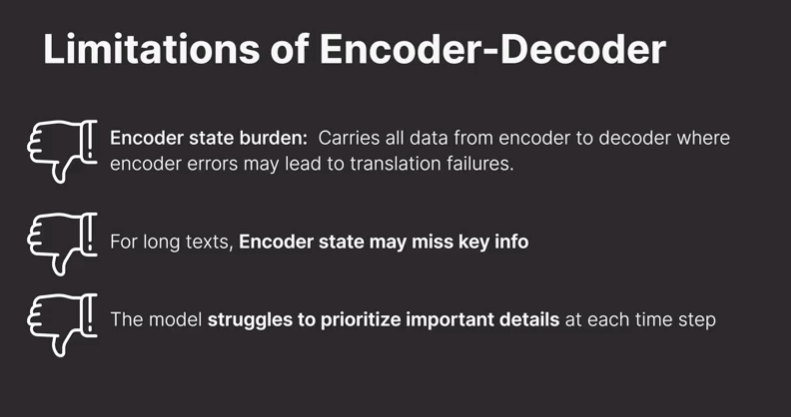

### So how will Attention improve these results?
* Without attention the focus is on every hidden state using an LSTM or RNN.
* With ATTENTION, the mechanism allows focus on only the important words or hidden states.
* We know that as sentence length increases, ATTENTION impact improves meaning more text is easily processed. We can see from the original paper below the BLEU Score is quite high the longer the sentence with ATTENTION.
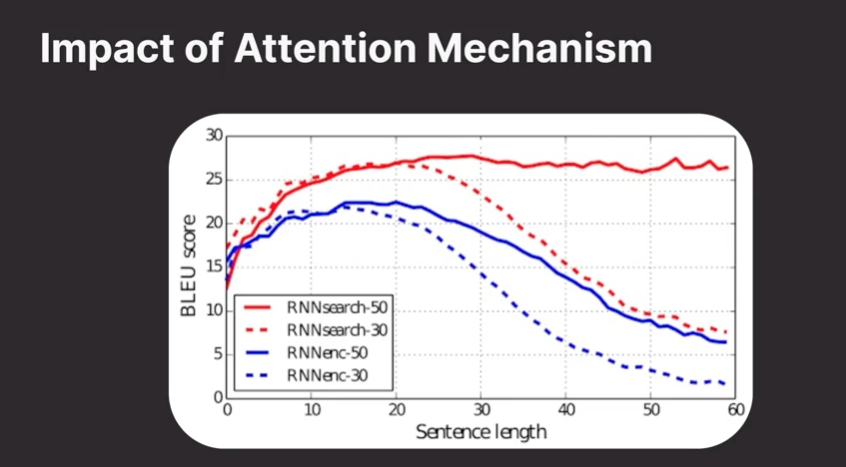

Key to ATTENTION: **Attention Context Vector**
* This is the weighted sum of the hidden states of the encoder as seen here:

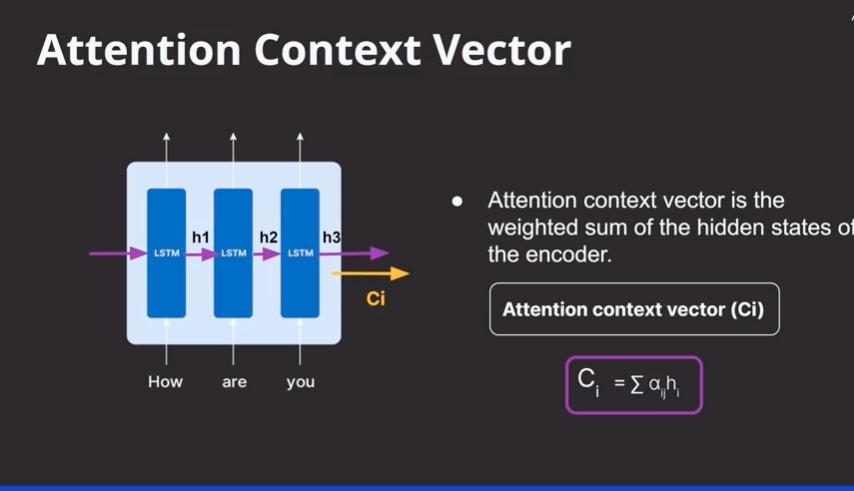